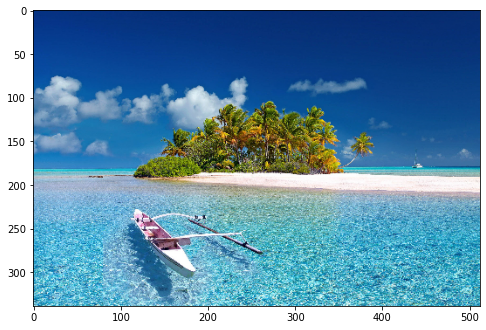

In [1]:
# 예제 8.58 : content 텍스처 불러오기
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

content_path = tf.keras.utils.get_file("content.jpg", "http://bit.ly/2mAfUX1")

content_image = plt.imread(content_path)
max_dim = 512
long_dim = max(content_image.shape[: -1])
scale = max_dim / long_dim

new_height = int(content_image.shape[0] * scale)
new_width = int(content_image.shape[1] * scale)

content_image = cv2.resize(content_image, dsize = (new_width, new_height))
content_image = content_image / 255.0
plt.figure(figsize = (8, 8))
plt.imshow(content_image)

In [0]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top = False, weights = 'imagenet')

In [0]:
def get_outputs(image):
  image_batch = tf.expand_dims(image, axis = 0)
  output = model(preprocess_input(image_batch * 255.0))
  outputs = [gram_matrix(out) for out in output]

  return outputs

def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a = True)
  
  return gram / tf.cast(n, tf.float32)

def get_loss(outputs, style_outputs):
  return tf.reduce_sum([tf.reduce_mean((o - s) ** 2) for o, s in zip(outputs, style_outputs)])

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

def high_pass_x_y(image):
  x_var = image[:, 1:, :] - image[:, :-1, :]
  y_var = image[1:, :, :] - image[:-1, :, :]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas ** 2) + tf.reduce_mean(y_deltas ** 2)

style_path = tf.keras.utils.get_file("style.jpg", 'http://bit.ly/2mGfZIq')

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize = (224, 224))
style_image = style_image / 255.0

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

vgg.trainable = False

outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize = (224, 224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis = 0)
style_output = model(preprocess_input(style_batch * 255.0))

style_outputs = [gram_matrix(out) for out in style_output]

In [0]:
# 예제 8.59 : content 특징 추출 모델 만들기
content_batch = content_image.astype('float32')
content_batch = tf.expand_dims(content_batch, axis = 0)

content_layers = ['block5_conv2']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in content_layers]
model_content = tf.keras.Model([vgg.input], outputs)
content_output = model_content(preprocess_input(content_batch * 255.0))

In [0]:
# 예제 8.60 : content output, loss 함수 정의
def get_content_output(image):
  image_batch = tf.expand_dims(image, axis = 0)
  output = model_content(preprocess_input(image_batch * 255.0))

  return output

def get_content_loss(image, content_output):
  return tf.reduce_sum(tf.reduce_mean(image - content_output) ** 2)

In [0]:
# 예제 8.61 : content loss를 손실 계산식에 추가
opt = tf.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.99, epsilon = 1e-1)

total_variation_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = get_outputs(image)
    output2 = get_content_output(image)
    loss = style_weight * get_loss(outputs, style_outputs)
    loss += content_weight * get_content_loss(output2, content_output)
    loss += total_variation_weight * total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

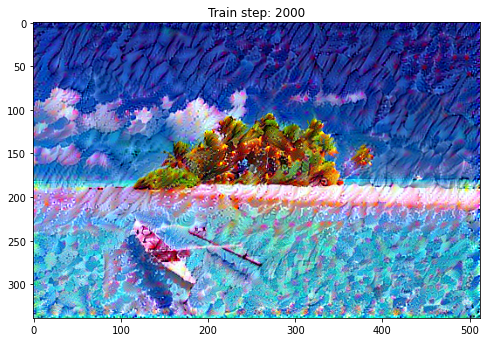

Total time: 269.9


In [7]:
# 예제 8.62 : 신경 스타일 전이 실행
import time
import imageio
import IPython.display as display

start = time.time()

# target_image = tf.random.uniform(content_image.shape)
image = tf.Variable(content_image.astype('float32'))

epochs = 20
steps_per_epoch = 100

step = 0

for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end = '')
  
  if n % 5 == 0 or n == epochs - 1:
    imageio.imwrite('style_{0}_content_{1}_transfer_epoch_{2}.png'.format(style_weight, content_weight, n), image.read_value().numpy())

  display.clear_output(wait = True)
  plt.figure(figsize = (8, 8))
  plt.imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end - start))